# **Credit Card Fraud Detection - EDA (Exploratory Data Analysis)**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import datetime
import optuna

#### There are 2 different data sets for model training:
#### 1) Transaction set includes general data of transactions
#### 2) Identity set includes identity datas of the transactions

In [4]:
train_transaction_df = pd.read_csv('../data/train_transaction.csv')
train_identity_df = pd.read_csv('../data/train_identity.csv')

In [5]:
train_transaction_df.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
train_identity_df.head(10)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
5,2987017,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,3.0,...,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
6,2987022,-15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987038,0.0,31964.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,...,chrome 62.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,NaN
8,2987040,-10.0,116098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
9,2987048,-5.0,257037.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


#### Since we have 2 datasets with different columns, we have to reduce it to a single dataset so we can work on it
#### **TransactionID** is the column we'll use for the join

In [8]:
train_df = pd.merge(train_transaction_df, train_identity_df, on='TransactionID', how='left')

In [9]:
train_df.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### There are **434** columns in this dataset
#### Even if we filter most of the columns, we have to design a standard template to make our work useful for other datasets

In [11]:
train_df.shape

(590540, 434)

#### Missing datas are a big issue in this dataset, we have to handle it carefully

<Axes: >

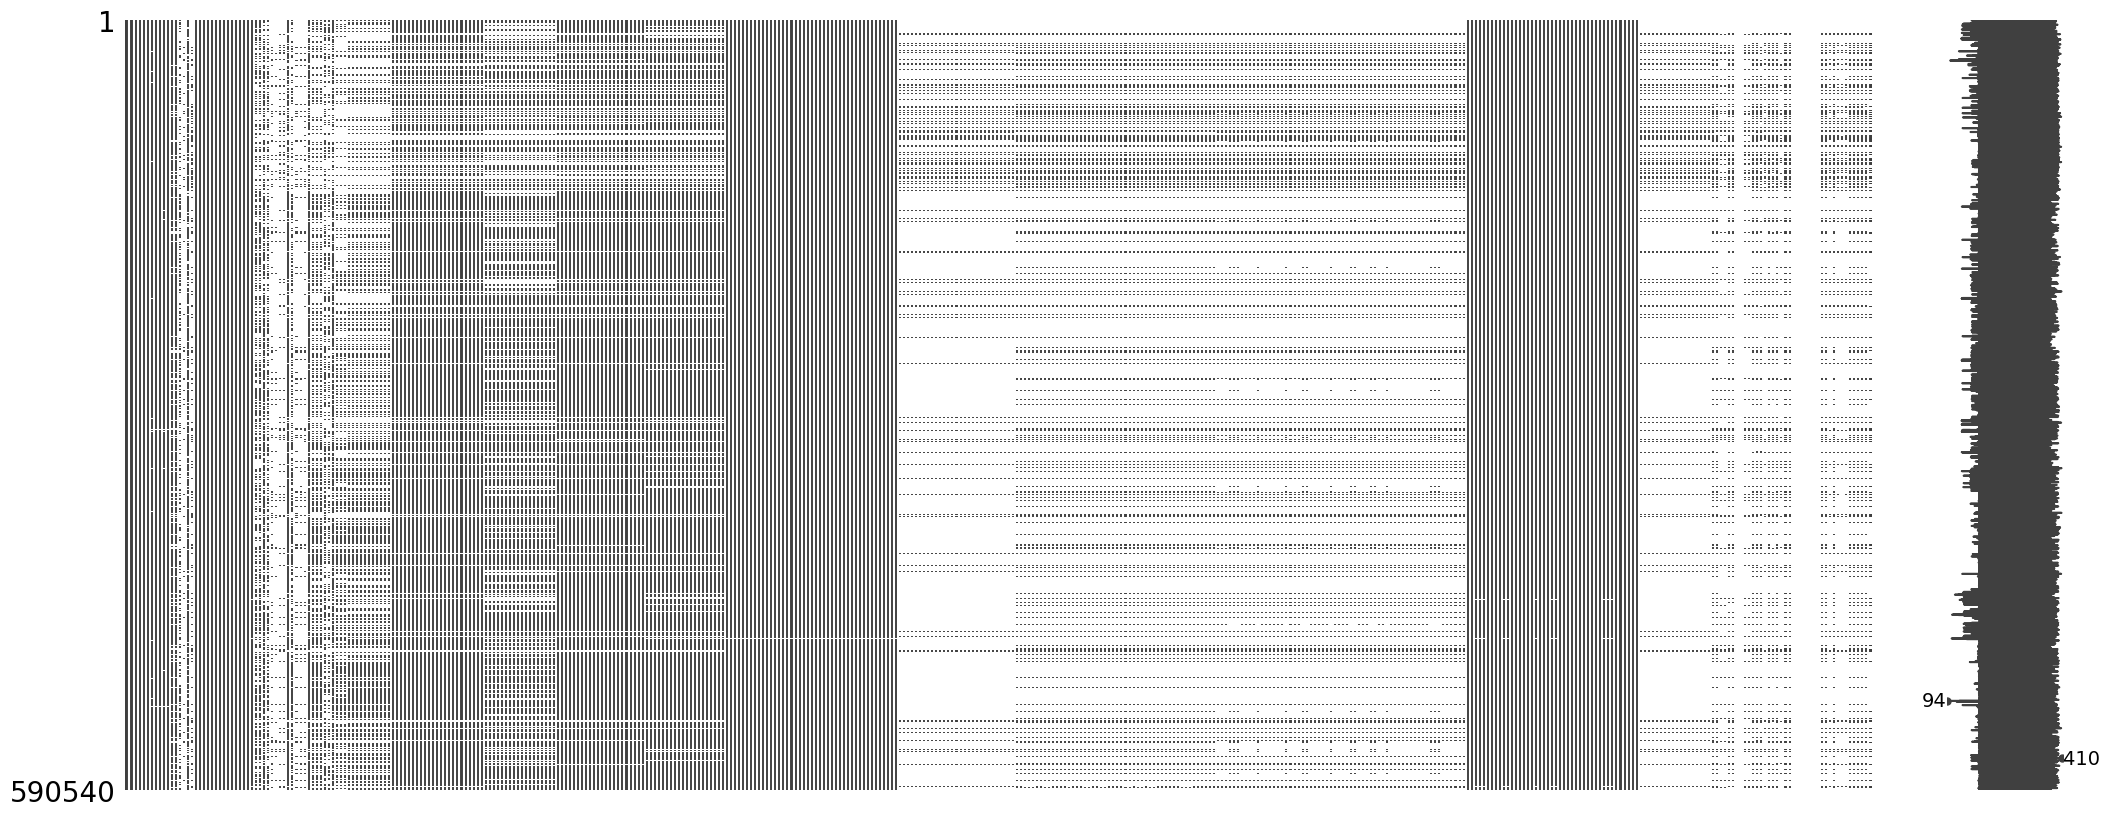

In [13]:
msno.matrix(train_df)

#### Fraud transaction percentage is around %3.5 for this dataset, it is a low rating that will make it harder to recognize fitting patterns
#### Due to imbalanced data we should stick to **AUC-ROC** instead of **Accuracy** as the target metric

In [15]:
train_df['isFraud'].value_counts(normalize=True)

isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64

<Axes: xlabel='isFraud', ylabel='count'>

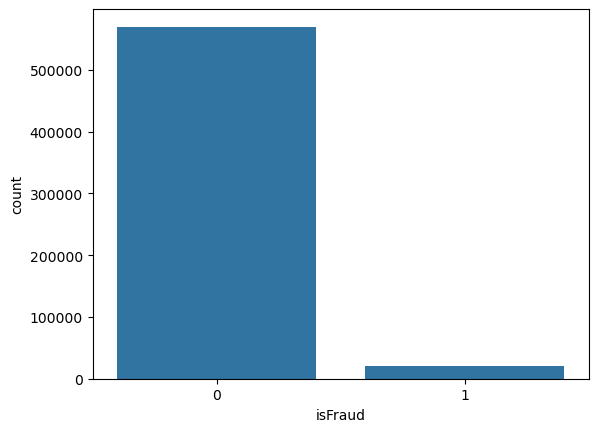

In [16]:
sns.countplot(x='isFraud', data=train_df)

## Primary Data Preprocessing
### Target column will be given and features will be extracted

In [18]:
TARGET = 'isFraud'

In [19]:
features_to_exclude = [TARGET, 'TransactionID']

In [20]:
categorical_features = []
numerical_features = []

In [21]:
df_processed = train_df.copy()

In [22]:
for col in df_processed.columns:
    if col not in features_to_exclude:
        if train_df[col].dtype == 'object':
            categorical_features.append(col)
        else:
            numerical_features.append(col)

### Checking the feature types to give them a shape so we can work on it onwards

In [24]:
len(categorical_features)

31

In [25]:
categorical_features[:5]

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain']

In [26]:
len(numerical_features)

401

In [27]:
numerical_features[:5]

['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3']

In [28]:
df_processed['P_emaildomain'].head(10)

0              NaN
1        gmail.com
2      outlook.com
3        yahoo.com
4        gmail.com
5        gmail.com
6        yahoo.com
7         mail.com
8    anonymous.com
9        yahoo.com
Name: P_emaildomain, dtype: object

### One-hot encoding will be used because of the nominal data
#### We need to eliminate the missing rows, but first we need to have a better understanding of data to decide which technique will be used (filling with mean or median values)

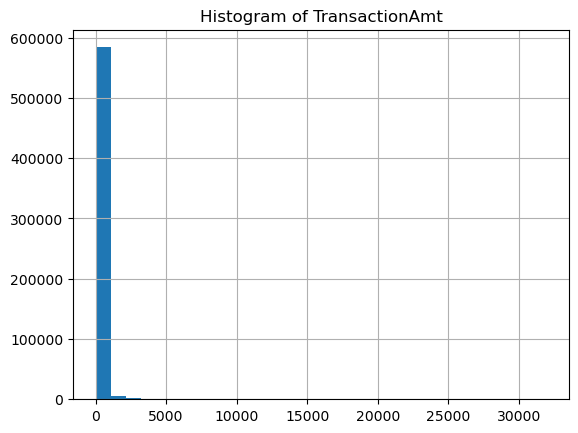

In [30]:
df_processed["TransactionAmt"].hist(bins=30)
plt.title("Histogram of TransactionAmt")
plt.show()

In [31]:
df_processed["TransactionAmt"].skew()

14.374489573829827

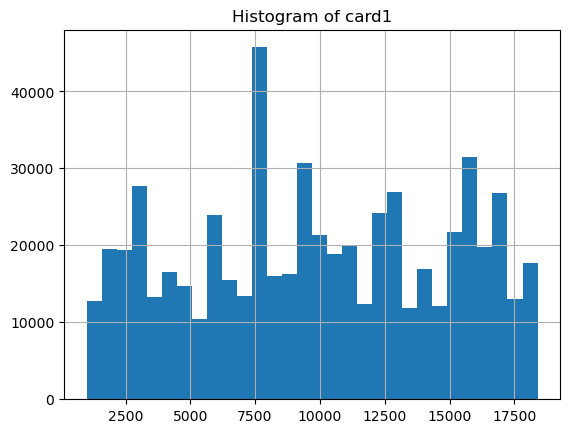

In [32]:
df_processed["card1"].hist(bins=30)
plt.title("Histogram of card1")
plt.show()

In [33]:
df_processed["card1"].skew()

-0.040928983534335904

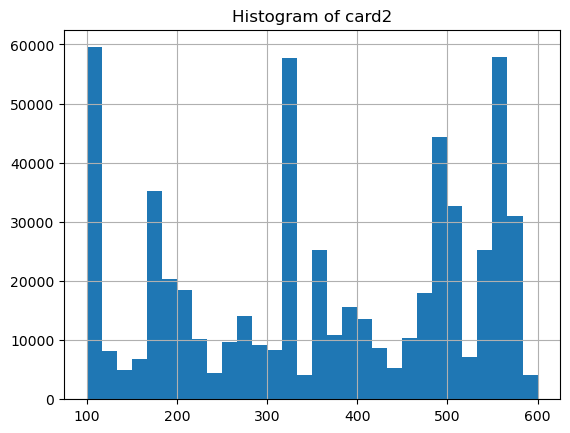

In [34]:
df_processed["card2"].hist(bins=30)
plt.title("Histogram of card2")
plt.show()

In [35]:
df_processed["card2"].skew()

-0.20000860852370972

In [36]:
df_processed["addr2"].skew()

-14.50115337134165

### After an exploration we can see that; some columns are **normally distributed**, some columns has **low skewness**, some columns has **high skewness** at both sides (negative and positive)
### So we should handle each column by it's characteristic
### Next step is to group columns, make strategies for each group, feature extraction and feature reducing

In [38]:
all_columns = df_processed.columns.tolist()

In [39]:
transaction_info_cols = ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD']

In [40]:
card_info_cols = [col for col in all_columns if col.startswith('card')]
card_info_cols += [col for col in all_columns if col.startswith('addr')]
card_info_cols += [col for col in all_columns if col.startswith('dist')]

In [41]:
email_cols = ['P_emaildomain', 'R_emaildomain']

In [42]:
m_match_cols = [col for col in all_columns if col.startswith('M')]

In [43]:
d_timedelta_cols = [col for col in all_columns if col.startswith('D') and col[1:].isdigit()]

In [44]:
c_counter_cols = [col for col in all_columns if col.startswith('C')]

In [45]:
v_vesta_cols = [col for col in all_columns if col.startswith('V')]

In [46]:
id_cols = [col for col in all_columns if col.startswith('id_')]
id_cols += ['DeviceType', 'DeviceInfo']

#### Groups are created and filled with related columns
#### We should inspect the groups and have a better understanding of data

In [48]:
len(transaction_info_cols)

5

In [49]:
len(card_info_cols)

10

In [50]:
len(email_cols)

2

In [51]:
len(m_match_cols)

9

In [52]:
len(d_timedelta_cols)

15

In [53]:
len(c_counter_cols)

14

In [54]:
len(v_vesta_cols)

339

In [55]:
len(id_cols)

40

#### Next step is to validate that none of the columns are outside of our grouping

In [57]:
grouped_cols = (
    transaction_info_cols +
    card_info_cols +
    email_cols +
    m_match_cols +
    d_timedelta_cols +
    c_counter_cols +
    v_vesta_cols +
    id_cols
)

In [58]:
len(df_processed.columns)

434

In [59]:
len(grouped_cols)

434

In [60]:
len(set(grouped_cols))

434

### Since we grouped our columns, now it's easier to spot missing datas per groups to determine our strategies

In [62]:
column_groups_dict = {
    'Transaction Info': transaction_info_cols,
    'Card Info': card_info_cols,
    'Email': email_cols,
    'M Match': m_match_cols,
    'Time Delta (D)': d_timedelta_cols,
    'Counter (C)': c_counter_cols,
    'Vesta (V)': v_vesta_cols,
    'Identity (ID)': id_cols
}

print("Average Missing Data Percentage in Each Column Family:")
print("-" * 55)

for group_name, cols in column_groups_dict.items():
    if not cols:
        continue
    
    total_cells = df_processed[cols].size
    missing_cells = df_processed[cols].isnull().sum().sum()
    
    if total_cells > 0:
        missing_percentage = (missing_cells / total_cells) * 100
    else:
        missing_percentage = 0
    
    print(f"{group_name:<20} | % {missing_percentage:.2f} missing data")

Average Missing Data Percentage in Each Column Family:
-------------------------------------------------------
Transaction Info     | % 0.00 missing data
Card Info            | % 17.86 missing data
Email                | % 46.37 missing data
M Match              | % 49.92 missing data
Time Delta (D)       | % 58.15 missing data
Counter (C)          | % 0.00 missing data
Vesta (V)            | % 43.04 missing data
Identity (ID)        | % 84.48 missing data


In [63]:
new_missing_indicators = {}

In [64]:
for col in df_processed.columns:
    if df_processed[col].isnull().mean() > 0.15:
        new_column_name = f'{col}_is_missing'
        new_missing_indicators[new_column_name] = df_processed[col].isnull().astype(int)

In [65]:
print(len(new_missing_indicators))
df_missing_indicators = pd.DataFrame(new_missing_indicators)

274


In [66]:
df_processed = pd.concat([df_processed, df_missing_indicators], axis=1)

In [67]:
df_processed = df_processed.copy()

In [68]:
df_processed.shape[1]

708

#### Column count increased significantly but the reason behind this is the missing data problem
#### We will get rid of "useless" columns after we detect it and we'll remove them safely without harming our data
#### If missing value informations are being stored in a different column, it will be helpful while using **LightGBM/XGBoost**

## **Feature Engineering**
### Creating Unique ID
#### Creating an unique ID gives us a point of view that we can track different scenarios based on different users/profiles

In [71]:
df_processed['CustomerID'] = df_processed['card1'].astype(str) + '_' + \
                             df_processed['card2'].astype(str) + '_' + \
                             df_processed['card3'].astype(str) + '_' + \
                             df_processed['card4'].astype(str) + '_' + \
                             df_processed['card5'].astype(str) + '_' + \
                             df_processed['card6'].astype(str) + '_' + \
                             df_processed['addr1'].astype(str)

### Grouping and Aggregation

In [73]:
agg_funcs = {'TransactionAmt': ['mean', 'std']}
customer_agg_df = df_processed.groupby('CustomerID').agg(agg_funcs)

In [74]:
customer_agg_df.columns = ['_'.join(col).strip() for col in customer_agg_df.columns.values]

In [75]:
df_processed = pd.merge(df_processed, customer_agg_df, on='CustomerID', how='left')

### Interaction Features

In [77]:
df_processed['TransactionAmt_to_Mean'] = df_processed['TransactionAmt'] / (df_processed['TransactionAmt_mean'] + 1e-6)

In [78]:
df_processed['TransactionAmt_to_Std'] = df_processed['TransactionAmt'] / (df_processed['TransactionAmt_std'] + 1e-6)

#### If we need to detect **anomalies** then we need to declare a **normal**
#### If we detect something that is not usual then we call it an **anomaly**

### Label Encoding
#### Categorical datas are being transformed to numerical labels

In [81]:
categorical_cols = df_processed.select_dtypes(include=['object']).columns

In [82]:
len(categorical_cols)

32

In [83]:
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))

In [84]:
X = df_processed.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1)
y = df_processed['isFraud']

In [85]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [86]:
oof_preds = np.zeros(len(df_processed))

In [87]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"--- FOLD {fold+1} ---")
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    lgb_clf = lgb.LGBMClassifier(n_estimators=1000, random_state=42)
    
    lgb_clf.fit(X_train, y_train, 
              eval_set=[(X_val, y_val)], 
              eval_metric='auc', 
              callbacks=[lgb.early_stopping(100, verbose=False)])
    
    val_preds = lgb_clf.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = val_preds

--- FOLD 1 ---
[LightGBM] [Info] Number of positive: 16531, number of negative: 455901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.817159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40612
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 709
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034991 -> initscore=-3.317038
[LightGBM] [Info] Start training from score -3.317038
--- FOLD 2 ---
[LightGBM] [Info] Number of positive: 16531, number of negative: 455901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.925733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40614
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 709
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034991 -> initscore=-3.317038
[LightGBM] [Info] Start trai

In [88]:
oof_auc_score = roc_auc_score(y, oof_preds)
print(f"\nTraining completed! Overall Out-of-Fold AUC Score: {oof_auc_score:.5f}")


Training completed! Overall Out-of-Fold AUC Score: 0.96563


## **Summary**
### We've trained our model and tested it using LightGBM
### As a result, model achieved approximately **%96.5 ROG-AUC** score
#### That makes our model successful, **but** since the topic is **Credit Card Fraud Detection** and every fraud is a valuable subject itself, we have to try to optimize our dataframe/model to optimize the results

## Deeper Into Feature Engineering

In [91]:
df_processed['TransactionHour'] = (df_processed['TransactionDT'] // 3600) % 24

In [92]:
df_processed['TransactionDayOfWeek'] = (df_processed['TransactionDT'] // 86400) % 7

In [93]:
print(df_processed[['TransactionDT', 'TransactionHour', 'TransactionDayOfWeek']].head())

   TransactionDT  TransactionHour  TransactionDayOfWeek
0          86400                0                     1
1          86401                0                     1
2          86469                0                     1
3          86499                0                     1
4          86506                0                     1


### Formatting the time passed after last transaction above

### We need to optimize and add aggregate functions and do modifications about columns to optimize our model

In [96]:
agg_funcs = {'D15': ['mean', 'std']}
customer_d15_agg = df_processed.groupby('CustomerID').agg(agg_funcs)
customer_d15_agg.columns = ['CustomerID_D15_mean', 'CustomerID_D15_std']
df_processed = pd.merge(df_processed, customer_d15_agg, on='CustomerID', how='left')

In [97]:
df_processed['email_domain_freq'] = df_processed['P_emaildomain'].map(df_processed['P_emaildomain'].value_counts(dropna=False))

In [98]:
df_processed.fillna(-999, inplace=True)

### Filled missing values with -999 so we'll know if an user has only a single transaction

## **Model Training & Testing - Second Attempt**

In [101]:
X = df_processed.drop(['isFraud', 'TransactionID', 'TransactionDT', 'CustomerID'], axis=1)
y = df_processed['isFraud']

In [102]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(df_processed))
feature_importances = pd.DataFrame(index=X.columns)

In [ ]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"--- FOLD {fold+1} ---")
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    lgb_clf = lgb.LGBMClassifier(n_estimators=1000, random_state=42) # Temel parametrelerle
    lgb_clf.fit(X_train, y_train, 
              eval_set=[(X_val, y_val)], 
              eval_metric='auc', 
              callbacks=[lgb.early_stopping(100, verbose=False)])
    
    val_preds = lgb_clf.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = val_preds
    feature_importances[f'fold_{fold+1}'] = lgb_clf.feature_importances_

--- FOLD 1 ---
[LightGBM] [Info] Number of positive: 16531, number of negative: 455901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.705470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40967
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 713
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034991 -> initscore=-3.317038
[LightGBM] [Info] Start training from score -3.317038
--- FOLD 2 ---
[LightGBM] [Info] Number of positive: 16531, number of negative: 455901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.472307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40969
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 713
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034991 -> initscore=-3.317038
[LightGBM] [Info] Start trai

In [ ]:
oof_auc_score = roc_auc_score(y, oof_preds)
print(f"\nTraining completed! Overall Out-of-Fold AUC Score: {oof_auc_score:.5f}")

### ROC-AUC score has improved around 0.001, it shows us that there's no visible changes
### Next step is to get rid of useless columns

In [ ]:
feature_importances['mean_importance'] = feature_importances.mean(axis=1)
feature_importances.sort_values(by='mean_importance', ascending=False, inplace=True)

In [ ]:
zero_importance_features = feature_importances[feature_importances['mean_importance'] == 0].index.tolist()

In [ ]:
print(f"\nThe model found {len(zero_importance_features)} features with zero importance.")
print(f"Example: {zero_importance_features[:10]}")

In [ ]:
print(f"Number of original features: {X.shape[1]}")
X_reduced = X.drop(columns=zero_importance_features)

print(f"Number of features after dropping those with zero importance: {X_reduced.shape[1]}")

In [ ]:
X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [ ]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1, # Logları kapatır
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 16),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_opt, y_train_opt,
              eval_set=[(X_val_opt, y_val_opt)],
              eval_metric='auc',
              callbacks=[lgb.early_stopping(100, verbose=False)])
    
    preds = model.predict_proba(X_val_opt)[:, 1]
    auc = roc_auc_score(y_val_opt, preds)
    return auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

In [ ]:
print(f"Best trial's AUC score: {study.best_value:.5f}")
print("Best hyperparameters:")
print(study.best_params)

In [ ]:
best_params = study.best_params
best_params['random_state'] = 42